In [ ]:

import numpy as np
import os
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from scipy.spatial import cKDTree
import plotly.graph_objects as go
import numpy as np
import plotly.io as pio
pio.renderers.default = "browser"



In [30]:
## Helper function

''' Converts black box functions from np.arrays to pandas.DataFrames for easier interpretation of tabular data
Inputs:
    npa_x       inputs x1,x2,... as np array
    npa_y       output y as np array

Outputs:
    df          Dataframe with columns x1, x2, ... and y
'''

def fcn_as_df(npa_x,npa_y):
    # assure that even single rows have two dimensions - avoids breaking code below
    if npa_x.ndim == 1:
        npa_x = npa_x.reshape(1,-1)
        npa_y = npa_y.reshape(1,-1)

    n_col = npa_x.shape[1]
    col_names = [f"x{i+1}" for i in range(n_col)]
    df = pd.DataFrame(npa_x,columns=col_names)
    df["y"] = np.ravel(npa_y).T
    return df

''' Helper - Reads numpy arrays for each of the eight functions from disk and returns a list of dataframes containing the input and output info

Inputs: 
    path_to_fcns    Directory path - must contain folders "function_1","function_2"... each containing inputs.npy and outputs.npy 

Outputs: 
    fcn_dict - Dictionary of dataframes for each function, each dataframe containing columns x1, x2,..., y
'''


def read_fcns_from_disk(path_to_fcns):
    f_in = []
    f_out = []
    num_functions = 8
    # read the functions as a list of numpy arrays, separate for inputs x and output y
    for i in range(0, num_functions):
        dir_path = os.path.join(path_to_fcns, f'function_{i+1}')
        inputs = np.load(os.path.join(dir_path, 'inputs.npy'))
        outputs = np.load(os.path.join(dir_path, 'outputs.npy'))
        f_in.append(inputs)
        f_out.append(outputs)
        
    # create a dictionary of form {"f_1": DataFrame, "f_2": DataFrame, } where the DataFrames have column names x1, x2, ..., y
    fcn_dict = {}
    for i in range(0, num_functions):
        npa_x = f_in[i]
        npa_y = f_out[i]

        fcn_dict[f"f_{i+1}"] = fcn_as_df(npa_x,npa_y)

    return fcn_dict




# Utility: Signed log scaling
For functions whose output varies by many orders of magnitude, log scaling prevents Gaussian Process models from being "dominated" by a single point.  For example, the function `f1` has values ranging from approx -3*10-3 to about 1*10-190.  

In [31]:
def signed_log10(y):
    return np.sign(y) * np.log10(np.abs(y) + 1e-100)  # add small epsilon to avoid log(0)


In [32]:

latest_data_dir = os.path.join(".","measurements","latest")
f_dict = read_fcns_from_disk(latest_data_dir)

for k in f_dict.keys():
    print(k)
    print("---")
    print(f_dict[k])



f_1
---
          x1        x2              y
0   0.319404  0.762959   1.322677e-79
1   0.574329  0.879898   1.033078e-46
2   0.731024  0.733000   7.710875e-16
3   0.840353  0.264732  3.341771e-124
4   0.650114  0.681526  -3.606063e-03
5   0.410437  0.147554  -2.159249e-54
6   0.312691  0.078723  -2.089093e-91
7   0.683418  0.861057   2.535001e-40
8   0.082507  0.403488   3.606771e-81
9   0.883890  0.582254   6.229856e-48
10  0.997304  1.000000  3.215893e-191
11  0.653061  0.204082   5.750007e-71
f_2
---
          x1        x2         y
0   0.665800  0.123969  0.538996
1   0.877791  0.778628  0.420586
2   0.142699  0.349005 -0.065624
3   0.845275  0.711120  0.293993
4   0.454647  0.290455  0.214965
5   0.577713  0.771973  0.023106
6   0.438166  0.685018  0.244619
7   0.341750  0.028698  0.038749
8   0.338648  0.213867 -0.013858
9   0.702637  0.926564  0.611205
10  0.758325  1.000000  0.240588
11  0.000000  0.000000 -0.008867
f_3
---
          x1        x2        x3         y
0   0.1715

In [33]:
# Helper function to print query point in expected format

def format_query(queryPoint):
    
    print(f"queryPoint={queryPoint}")

    # print the elements of the vector queryPoint, in the format 0.000000-0.000000-0.000000
    # where there is one 0.000000 per element in the vector

    query_str = '-'.join([f"{elem:.6f}" for elem in np.ravel(queryPoint)])
    print(f"queryPoint (formatted)={query_str}")

    #query_str=""
    #query_str.join(f"{queryPoint[0]:.6f}")
    #query_str.join([f"{elem:.6f}" for elem in np.ravel(queryPoint[1:])])
    #print(f"queryPoint (formatted)={query_str}")

In [44]:

# pick out function 1
k = "f_1"
f = f_dict[k]
print("f1 with latest data")
print(f)

row_of_max = f["y"].idxmax()
print(f"Best row so far")
print(f.loc[[row_of_max]])

y_train = f.iloc[:,-1].to_numpy()  # output is in last column
X_train = f.iloc[:,:-1].to_numpy() # other columns are inputs

y_train[y_train<=0] = 10e-200

print("outliers imputed")
print(y_train.T)

print("log")
y_train = np.log10(y_train)
print(y_train.T)

np.random.seed(0)
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[1.0, 1.0], nu=2.5) + WhiteKernel(noise_level=0)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
gp.fit(X_train, y_train)

x1 = np.linspace(0, 1, 50)
x2 = np.linspace(0, 1, 50)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.vstack((X1.ravel(), X2.ravel())).T

# --- Step 5. Predict mean and std from the GP ---
y_mean, y_std = gp.predict(X_grid, return_std=True)

# --- Step 6. Define the UCB (Upper Confidence Bound) acquisition function ---
beta = 2.0  # exploration parameter
ucb = y_mean + beta * y_std

# --- Step 7. Select next acquisition point ---
next_idx = np.argmax(ucb)
X_next = X_grid[next_idx]
print("Next acquisition point (UCB):", X_next)

format_query(X_next)

print("Looking for points far from current query points...")

# Build a KD-tree for fast nearest-neighbor lookup
tree = cKDTree(X_train)

# Compute the distance from each grid point to its nearest existing sample
distances, _ = tree.query(X_grid, k=1)

# Sort the grid points by descending distance
idx_sorted = np.argsort(-distances)

# Pick the top N most unexplored points (farthest from existing data)
N = 4
unexplored_points = X_grid[idx_sorted[:N]]

# Optional: print or visualize
print("Most unexplored points (farthest from training data):")
print(unexplored_points)
print("point this week")
format_query(unexplored_points[0,:])




f1 with latest data
          x1        x2              y
0   0.319404  0.762959   1.322677e-79
1   0.574329  0.879898   1.033078e-46
2   0.731024  0.733000   7.710875e-16
3   0.840353  0.264732  3.341771e-124
4   0.650114  0.681526  1.000000e-199
5   0.410437  0.147554  1.000000e-199
6   0.312691  0.078723  1.000000e-199
7   0.683418  0.861057   2.535001e-40
8   0.082507  0.403488   3.606771e-81
9   0.883890  0.582254   6.229856e-48
10  0.997304  1.000000  3.215893e-191
11  0.653061  0.204082   5.750007e-71
Best row so far
         x1     x2             y
2  0.731024  0.733  7.710875e-16
outliers imputed
[1.32267704e-079 1.03307824e-046 7.71087511e-016 3.34177101e-124
 1.00000000e-199 1.00000000e-199 1.00000000e-199 2.53500115e-040
 3.60677119e-081 6.22985647e-048 3.21589310e-191 5.75000684e-071]
log
[ -78.87854619  -45.98586679  -15.11289633 -123.47602331 -199.
 -199.         -199.          -39.59602184  -80.44288141  -47.20552196
 -190.4926984   -70.24033164]
Next acquisition point 

/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:305: RuntimeWarning:

divide by zero encountered in log

/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.



# Contour plots of the Gaussian Process model and the measured datapoints - matplotlib and plotly interactive


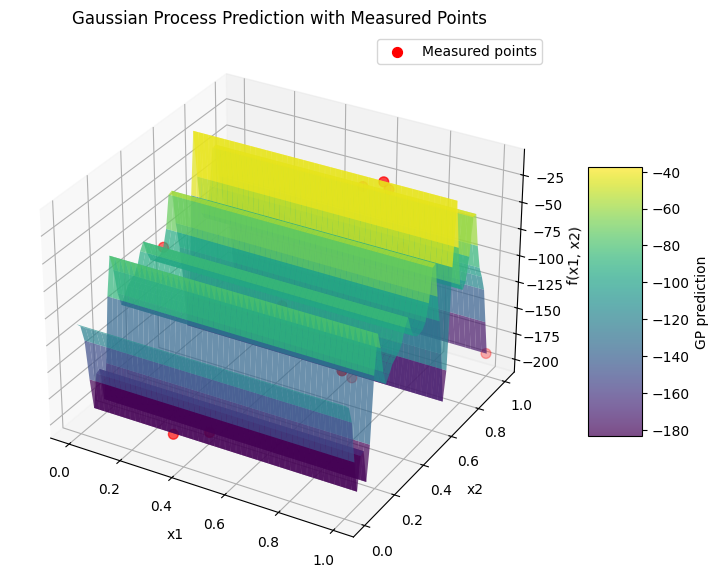

In [41]:

y_GP = y_mean.reshape(X1.shape)

# ----------------------------
# Plot GP surface and measured points
# ----------------------------
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Surface plot of GP
surf = ax.plot_surface(X1, X2, y_GP, cmap='viridis', alpha=0.7)

# Overlay measured points
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, color='red', s=50, label='Measured points')

# Labels and colorbar
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f(x1, x2)')
ax.set_title('Gaussian Process Prediction with Measured Points')
fig.colorbar(surf, shrink=0.5, aspect=5, label='GP prediction')

ax.legend()
plt.show()

# Interactive plot

fig = go.Figure(data=[go.Surface(z=y_GP, x=X1, y=X2, opacity=0.4)])
fig.update_layout(scene=dict(
    xaxis_title='x1',
    yaxis_title='x2',
    zaxis_title='f(x1,x2)'
))
fig.show()

fig.add_trace(go.Scatter3d(
    x=X_train[:, 0],
    y=X_train[:, 1],
    z=y_train,
    mode='markers',
    marker=dict(color='red', size=5),
    name='Measured points'
))
fig.show()


# f_2()


In [53]:

# fit RBF to f2

# pick out function 2
k = "f_2"
f = f_dict[k]

print("f1 with latest data")
print(f)

row_of_max = f["y"].idxmax()
print(f"Best row so far")
print(f.loc[[row_of_max]])

y_train = f.iloc[:,-1].to_numpy()  # output is in last column
X_train = f.iloc[:,:-1].to_numpy() # other columns are inputs

np.random.seed(0)
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[1.0, 1.0], nu=2.5) + WhiteKernel(noise_level=1e-5)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
gp.fit(X_train, y_train)

x1 = np.linspace(0, 1, 50)
x2 = np.linspace(0, 1, 50)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.vstack((X1.ravel(), X2.ravel())).T

# --- Step 5. Predict mean and std from the GP ---
y_mean, y_std = gp.predict(X_grid, return_std=True)

# --- Step 6. Define the UCB (Upper Confidence Bound) acquisition function ---
beta = 2.0  # exploration parameter
ucb = y_mean + beta * y_std

# --- Step 7. Select next acquisition point ---
next_idx = np.argmax(ucb)
X_next = X_grid[next_idx]
print("Next acquisition point (UCB):", X_next)

format_query(X_next)

print("Looking for points far from current query points...")

# Build a KD-tree for fast nearest-neighbor lookup
tree = cKDTree(X_train)

# Compute the distance from each grid point to its nearest existing sample
distances, _ = tree.query(X_grid, k=1)

# Sort the grid points by descending distance
idx_sorted = np.argsort(-distances)

# Pick the top N most unexplored points (farthest from existing data)
N = 4
unexplored_points = X_grid[idx_sorted[:N]]

# Optional: print or visualize
print("Most unexplored points (farthest from training data):")
print(unexplored_points)
print("point this week")
format_query(unexplored_points[0,:])


f1 with latest data
          x1        x2         y
0   0.665800  0.123969  0.538996
1   0.877791  0.778628  0.420586
2   0.142699  0.349005 -0.065624
3   0.845275  0.711120  0.293993
4   0.454647  0.290455  0.214965
5   0.577713  0.771973  0.023106
6   0.438166  0.685018  0.244619
7   0.341750  0.028698  0.038749
8   0.338648  0.213867 -0.013858
9   0.702637  0.926564  0.611205
10  0.758325  1.000000  0.240588
11  0.000000  0.000000 -0.008867
Best row so far
         x1        x2         y
9  0.702637  0.926564  0.611205
Next acquisition point (UCB): [0.         0.02040816]
queryPoint=[0.         0.02040816]
queryPoint (formatted)=0.000000-0.020408
Looking for points far from current query points...
Most unexplored points (farthest from training data):
[[0.         1.        ]
 [0.         0.97959184]
 [0.02040816 1.        ]
 [0.         0.95918367]]
point this week
queryPoint=[0. 1.]
queryPoint (formatted)=0.000000-1.000000


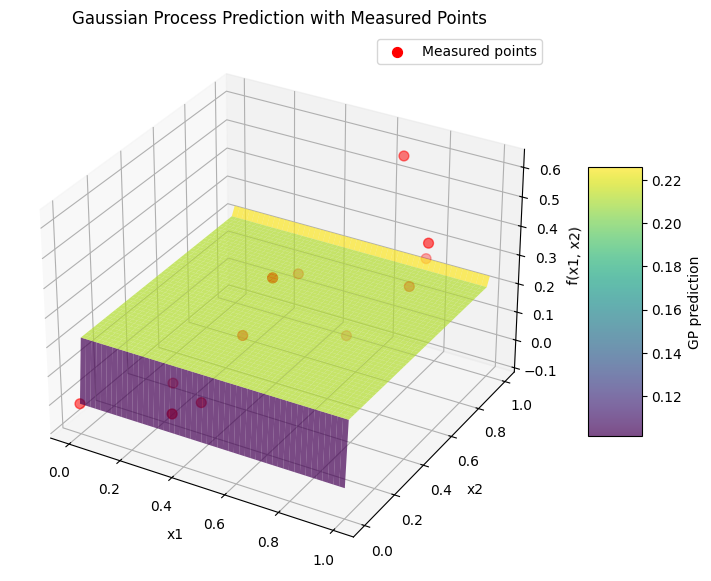

In [54]:
y_GP = y_mean.reshape(X1.shape)

# ----------------------------
# Plot GP surface and measured points
# ----------------------------
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Surface plot of GP
surf = ax.plot_surface(X1, X2, y_GP, cmap='viridis', alpha=0.7)

# Overlay measured points
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, color='red', s=50, label='Measured points')

# Labels and colorbar
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f(x1, x2)')
ax.set_title('Gaussian Process Prediction with Measured Points')
fig.colorbar(surf, shrink=0.5, aspect=5, label='GP prediction')

ax.legend()
plt.show()

# Interactive plot

fig = go.Figure(data=[go.Surface(z=y_GP, x=X1, y=X2, opacity=0.5)])
fig.update_layout(scene=dict(
    xaxis_title='x1',
    yaxis_title='x2',
    zaxis_title='f(x1,x2)'
))
fig.show()

fig.add_trace(go.Scatter3d(
    x=X_train[:, 0],
    y=X_train[:, 1],
    z=y_train,
    mode='markers',
    marker=dict(color='red', size=5),
    name='Measured points'
))
fig.show()


In [46]:
# fit RBF to f3

# pick out function 3
k = "f_3"
f = f_dict[k]

y_train = f.iloc[:,-1].to_numpy()  # output is in last column
X_train = f.iloc[:,:-1].to_numpy() # other columns are inputs

np.random.seed(0)
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[1.0, 1.0, 1.0], nu=2.5) + WhiteKernel(noise_level=1e-5)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
gp.fit(X_train, y_train)

x1 = np.linspace(0, 1, 50)
x2 = np.linspace(0, 1, 50)
x3 = np.linspace(0, 1, 50)
X1, X2, X3 = np.meshgrid(x1, x2, x3)
X_grid = np.vstack((X1.ravel(), X2.ravel(), X3.ravel())).T

# --- Step 5. Predict mean and std from the GP ---
y_mean, y_std = gp.predict(X_grid, return_std=True)

# --- Step 6. Define the UCB (Upper Confidence Bound) acquisition function ---
beta = 2.0  # exploration parameter
ucb = y_mean + beta * y_std

# --- Step 7. Select next acquisition point ---
next_idx = np.argmax(ucb)
X_next = X_grid[next_idx]
print("Next acquisition point (UCB):", X_next)

format_query(X_next)

print("Looking for points far from current query points...")

# Build a KD-tree for fast nearest-neighbor lookup
tree = cKDTree(X_train)

# Compute the distance from each grid point to its nearest existing sample
distances, _ = tree.query(X_grid, k=1)

# Sort the grid points by descending distance
idx_sorted = np.argsort(-distances)

# Pick the top N most unexplored points (farthest from existing data)
N = 4
unexplored_points = X_grid[idx_sorted[:N]]

# Optional: print or visualize
print("Most unexplored points (farthest from training data):")
print(unexplored_points)
print("point this week")
format_query(unexplored_points[0,:])

Next acquisition point (UCB): [0.         0.         0.65306122]
queryPoint=[0.         0.         0.65306122]
queryPoint (formatted)=0.000000-0.000000-0.653061
Looking for points far from current query points...
Most unexplored points (farthest from training data):
[[0.         1.         0.7755102 ]
 [0.         1.         0.79591837]
 [0.3877551  1.         1.        ]
 [0.02040816 1.         0.79591837]]
point this week
queryPoint=[0.        1.        0.7755102]
queryPoint (formatted)=0.000000-1.000000-0.775510


/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning:

The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.



In [47]:
# fit RBF to f4

# pick out function 4
k = "f_4"
f = f_dict[k]

y_train = f.iloc[:,-1].to_numpy()  # output is in last column
X_train = f.iloc[:,:-1].to_numpy() # other columns are inputs

np.random.seed(0)
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[1.0, 1.0, 1.0, 1.0], nu=2.5) + WhiteKernel(noise_level=1e-5)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
gp.fit(X_train, y_train)

x1 = np.linspace(0, 1, 50)
x2 = np.linspace(0, 1, 50)
x3 = np.linspace(0, 1, 50)
x4 = np.linspace(0, 1, 50)
X1, X2, X3, X4 = np.meshgrid(x1, x2, x3, x4)
X_grid = np.vstack((X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel())).T

# --- Step 5. Predict mean and std from the GP ---
y_mean, y_std = gp.predict(X_grid, return_std=True)

# --- Step 6. Define the UCB (Upper Confidence Bound) acquisition function ---
beta = 2.0  # exploration parameter
ucb = y_mean + beta * y_std

# --- Step 7. Select next acquisition point ---
next_idx = np.argmax(ucb)
X_next = X_grid[next_idx]
print("Next acquisition point (UCB):", X_next)

format_query(X_next)

print("Looking for points far from current query points...")

# Build a KD-tree for fast nearest-neighbor lookup
tree = cKDTree(X_train)

# Compute the distance from each grid point to its nearest existing sample
distances, _ = tree.query(X_grid, k=1)

# Sort the grid points by descending distance
idx_sorted = np.argsort(-distances)

# Pick the top N most unexplored points (farthest from existing data)
N = 4
unexplored_points = X_grid[idx_sorted[:N]]

# Optional: print or visualize
print("Most unexplored points (farthest from training data):")
print(unexplored_points)
print("point this week")
format_query(unexplored_points[0,:])



/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.



Next acquisition point (UCB): [0.42857143 0.40816327 0.26530612 0.44897959]
queryPoint=[0.42857143 0.40816327 0.26530612 0.44897959]
queryPoint (formatted)=0.428571-0.408163-0.265306-0.448980
Looking for points far from current query points...
Most unexplored points (farthest from training data):
[[0.         0.3877551  1.         1.        ]
 [0.         0.36734694 1.         1.        ]
 [0.         0.3877551  0.97959184 1.        ]
 [0.         0.3877551  1.         0.97959184]]
point this week
queryPoint=[0.        0.3877551 1.        1.       ]
queryPoint (formatted)=0.000000-0.387755-1.000000-1.000000


In [48]:
# fit RBF to f5

# pick out function 5
k = "f_5"
f = f_dict[k]

y_train = f.iloc[:,-1].to_numpy()  # output is in last column
X_train = f.iloc[:,:-1].to_numpy() # other columns are inputs

np.random.seed(0)
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[1.0, 1.0, 1.0, 1.0], nu=2.5) + WhiteKernel(noise_level=1e-5)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
gp.fit(X_train, y_train)

x1 = np.linspace(0, 1, 50)
x2 = np.linspace(0, 1, 50)
x3 = np.linspace(0, 1, 50)
x4 = np.linspace(0, 1, 50)
X1, X2, X3, X4 = np.meshgrid(x1, x2, x3, x4)
X_grid = np.vstack((X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel())).T

# --- Step 5. Predict mean and std from the GP ---
y_mean, y_std = gp.predict(X_grid, return_std=True)

# --- Step 6. Define the UCB (Upper Confidence Bound) acquisition function ---
beta = 2.0  # exploration parameter
ucb = y_mean + beta * y_std

# --- Step 7. Select next acquisition point ---
next_idx = np.argmax(ucb)
X_next = X_grid[next_idx]
print("Next acquisition point (UCB):", X_next)

format_query(X_next)

print("Looking for points far from current query points...")

# Build a KD-tree for fast nearest-neighbor lookup
tree = cKDTree(X_train)

# Compute the distance from each grid point to its nearest existing sample
distances, _ = tree.query(X_grid, k=1)

# Sort the grid points by descending distance
idx_sorted = np.argsort(-distances)

# Pick the top N most unexplored points (farthest from existing data)
N = 4
unexplored_points = X_grid[idx_sorted[:N]]

# Optional: print or visualize
print("Most unexplored points (farthest from training data):")
print(unexplored_points)
print("point this week")
format_query(unexplored_points[0,:])

Next acquisition point (UCB): [1. 0. 1. 0.]
queryPoint=[1. 0. 1. 0.]
queryPoint (formatted)=1.000000-0.000000-1.000000-0.000000
Looking for points far from current query points...
Most unexplored points (farthest from training data):
[[1.         1.         1.         0.81632653]
 [1.         1.         0.85714286 0.89795918]
 [1.         1.         0.87755102 0.87755102]
 [1.         1.         0.97959184 0.81632653]]
point this week
queryPoint=[1.         1.         1.         0.81632653]
queryPoint (formatted)=1.000000-1.000000-1.000000-0.816327


In [49]:
# fit RBF to f6

# pick out function 6
k = "f_6"
f = f_dict[k]

y_train = f.iloc[:,-1].to_numpy()  # output is in last column
X_train = f.iloc[:,:-1].to_numpy() # other columns are inputs

np.random.seed(0)
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[1.0, 1.0, 1.0, 1.0, 1.0], nu=2.5) + WhiteKernel(noise_level=1e-5)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
gp.fit(X_train, y_train)

x1 = np.linspace(0, 1, 20)
x2 = np.linspace(0, 1, 20)
x3 = np.linspace(0, 1, 20)
x4 = np.linspace(0, 1, 20)
x5 = np.linspace(0, 1, 20)
X1, X2, X3, X4, X5 = np.meshgrid(x1, x2, x3, x4, x5)
X_grid = np.vstack((X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel(), X5.ravel())).T

# --- Step 5. Predict mean and std from the GP ---
y_mean, y_std = gp.predict(X_grid, return_std=True)

# --- Step 6. Define the UCB (Upper Confidence Bound) acquisition function ---
beta = 2.0  # exploration parameter
ucb = y_mean + beta * y_std

# --- Step 7. Select next acquisition point ---
next_idx = np.argmax(ucb)
X_next = X_grid[next_idx]
print("Next acquisition point (UCB):", X_next)

format_query(X_next)

print("Looking for points far from current query points...")

# Build a KD-tree for fast nearest-neighbor lookup
tree = cKDTree(X_train)

# Compute the distance from each grid point to its nearest existing sample
distances, _ = tree.query(X_grid, k=1)

# Sort the grid points by descending distance
idx_sorted = np.argsort(-distances)

# Pick the top N most unexplored points (farthest from existing data)
N = 4
unexplored_points = X_grid[idx_sorted[:N]]

# Optional: print or visualize
print("Most unexplored points (farthest from training data):")
print(unexplored_points)
print("point this week")
format_query(unexplored_points[0,:])

Next acquisition point (UCB): [0.47368421 0.36842105 1.         1.         0.15789474]
queryPoint=[0.47368421 0.36842105 1.         1.         0.15789474]
queryPoint (formatted)=0.473684-0.368421-1.000000-1.000000-0.157895
Looking for points far from current query points...
Most unexplored points (farthest from training data):
[[1.         0.         1.         0.         1.        ]
 [0.94736842 0.         1.         0.         1.        ]
 [1.         0.         0.94736842 0.         1.        ]
 [1.         0.         1.         0.         0.94736842]]
point this week
queryPoint=[1. 0. 1. 0. 1.]
queryPoint (formatted)=1.000000-0.000000-1.000000-0.000000-1.000000


In [50]:
# fit RBF to f7

# pick out function 7
k = "f_7"
f = f_dict[k]

y_train = f.iloc[:,-1].to_numpy()  # output is in last column
X_train = f.iloc[:,:-1].to_numpy() # other columns are inputs

np.random.seed(0)
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], nu=2.5) + WhiteKernel(noise_level=1e-5)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
gp.fit(X_train, y_train)

x1 = np.linspace(0, 1, 10)
x2 = np.linspace(0, 1, 10)
x3 = np.linspace(0, 1, 10)
x4 = np.linspace(0, 1, 10)
x5 = np.linspace(0, 1, 10)
x6 = np.linspace(0, 1, 10)

X1, X2, X3, X4, X5, X6 = np.meshgrid(x1, x2, x3, x4, x5, x6)
X_grid = np.vstack((X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel(), X5.ravel(), X6.ravel())).T

# --- Step 5. Predict mean and std from the GP ---
y_mean, y_std = gp.predict(X_grid, return_std=True)

# --- Step 6. Define the UCB (Upper Confidence Bound) acquisition function ---
beta = 2.0  # exploration parameter
ucb = y_mean + beta * y_std

# --- Step 7. Select next acquisition point ---
next_idx = np.argmax(ucb)
X_next = X_grid[next_idx]
print("Next acquisition point (UCB):", X_next)

format_query(X_next)

print("Looking for points far from current query points...")

# Build a KD-tree for fast nearest-neighbor lookup
tree = cKDTree(X_train)

# Compute the distance from each grid point to its nearest existing sample
distances, _ = tree.query(X_grid, k=1)

# Sort the grid points by descending distance
idx_sorted = np.argsort(-distances)

# Pick the top N most unexplored points (farthest from existing data)
N = 4
unexplored_points = X_grid[idx_sorted[:N]]

# Optional: print or visualize
print("Most unexplored points (farthest from training data):")
print(unexplored_points)
print("point this week")
format_query(unexplored_points[0,:])

/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning:

The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning:

The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.



Next acquisition point (UCB): [1.         1.         0.         0.66666667 1.         0.33333333]
queryPoint=[1.         1.         0.         0.66666667 1.         0.33333333]
queryPoint (formatted)=1.000000-1.000000-0.000000-0.666667-1.000000-0.333333
Looking for points far from current query points...
Most unexplored points (farthest from training data):
[[0.         1.         1.         0.         1.         0.        ]
 [0.         1.         1.         0.         0.88888889 0.        ]
 [0.         1.         1.         0.         1.         0.11111111]
 [0.         0.88888889 1.         0.         1.         0.        ]]
point this week
queryPoint=[0. 1. 1. 0. 1. 0.]
queryPoint (formatted)=0.000000-1.000000-1.000000-0.000000-1.000000-0.000000


In [51]:
# fit RBF to f8

# pick out function 8
k = "f_8"
f = f_dict[k]

y_train = f.iloc[:,-1].to_numpy()  # output is in last column
X_train = f.iloc[:,:-1].to_numpy() # other columns are inputs

np.random.seed(0)
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], nu=2.5) + WhiteKernel(noise_level=1e-5)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
gp.fit(X_train, y_train)

x1 = np.linspace(0, 1, 5)
x2 = np.linspace(0, 1, 5)
x3 = np.linspace(0, 1, 5)
x4 = np.linspace(0, 1, 5)
x5 = np.linspace(0, 1, 5)
x6 = np.linspace(0, 1, 5)
x7 = np.linspace(0, 1, 5)
x8 = np.linspace(0, 1, 5)

X1, X2, X3, X4, X5, X6, X7, X8  = np.meshgrid(x1, x2, x3, x4, x5, x6, x7, x8)
X_grid = np.vstack((X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel(), X5.ravel(), X6.ravel(), X7.ravel(), X8.ravel())).T

# --- Step 5. Predict mean and std from the GP ---
y_mean, y_std = gp.predict(X_grid, return_std=True)

# --- Step 6. Define the UCB (Upper Confidence Bound) acquisition function ---
beta = 2.0  # exploration parameter
ucb = y_mean + beta * y_std

# --- Step 7. Select next acquisition point ---
next_idx = np.argmax(ucb)
X_next = X_grid[next_idx]
print("Next acquisition point (UCB):", X_next)

format_query(X_next)

print("Looking for points far from current query points...")

# Build a KD-tree for fast nearest-neighbor lookup
tree = cKDTree(X_train)

# Compute the distance from each grid point to its nearest existing sample
distances, _ = tree.query(X_grid, k=1)

# Sort the grid points by descending distance
idx_sorted = np.argsort(-distances)

# Pick the top N most unexplored points (farthest from existing data)
N = 4
unexplored_points = X_grid[idx_sorted[:N]]

# Optional: print or visualize
print("Most unexplored points (farthest from training data):")
print(unexplored_points)
print("point this week")
format_query(unexplored_points[0,:])

/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning:

The optimal value found for dimension 5 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning:

The optimal value found for dimension 7 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.



Next acquisition point (UCB): [0.   0.5  0.   0.5  1.   1.   0.25 1.  ]
queryPoint=[0.   0.5  0.   0.5  1.   1.   0.25 1.  ]
queryPoint (formatted)=0.000000-0.500000-0.000000-0.500000-1.000000-1.000000-0.250000-1.000000
Looking for points far from current query points...
Most unexplored points (farthest from training data):
[[0.   1.   0.   1.   0.   1.   0.   1.  ]
 [1.   0.   1.   1.   1.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   1.   0.   1.   0.   1.   0.   0.75]]
point this week
queryPoint=[0. 1. 0. 1. 0. 1. 0. 1.]
queryPoint (formatted)=0.000000-1.000000-0.000000-1.000000-0.000000-1.000000-0.000000-1.000000
